# 1. Regression

## 1.1. Load Data and Train Model

# SHAP Metrics

In [3]:
import sys

sys.path.insert(0, "/home/cristian/holisticai/src")

In [30]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from collections import Counter

def feature_rank_stability(local_importances):
    """
    Calculates the rank stability (RSt) for a set of ranked features derived from local feature importances.

    Args:
        local_importances (np.array): A matrix of shape (M, d), where M is the number of samples 
                                      and d is the number of features. Each entry represents the importance of a feature in a sample.
    
    Returns:
        float: The rank stability (RSt) value between 0 and 1.
    """
    # Convert local importances to rankings (higher importance gets a lower rank)
    ranked_features = np.argsort(-local_importances, axis=1)  # Sort each row in descending order, giving ranks
    
    # Number of iterations
    n = len(ranked_features)
    
    # Flatten the ranked features list and get the unique features
    unique_features = list(set([feature for iteration in ranked_features for feature in iteration]))
    
    # Initialize a dictionary to store ranks for each feature
    feature_ranks = {feature: [] for feature in unique_features}
    
    # Populate ranks for each feature
    for iteration in ranked_features:
        for rank, feature in enumerate(iteration, start=1):
            feature_ranks[feature].append(rank)
    
    # Calculate rank stability for each feature
    def rank_stability(feature_rankings):
        if len(feature_rankings) == 1:
            return 1.0  # If a feature is ranked only once, its stability is maximal
        
        # Find the most frequent (consistent) rank
        rank_counter = Counter(feature_rankings)
        most_frequent_rank = rank_counter.most_common(1)[0][0]
        
        # Calculate actual deviation (sum of absolute differences from the most frequent rank)
        actual_deviation = sum(abs(rank - most_frequent_rank) for rank in feature_rankings)
        
        # Calculate maximum deviation
        max_deviation = len(feature_rankings) * (max(feature_rankings) - min(feature_rankings))
        
        if max_deviation == 0:
            return 1.0  # If there's no variation, stability is maximal
        
        # Calculate and return rank stability
        return 1 - (actual_deviation / max_deviation)
    
    # Calculate overall rank stability for the system
    overall_stability = np.mean([rank_stability(feature_ranks[feature]) for feature in unique_features])
    
    return overall_stability

def feature_importance_stability(feature_importances):
    """
    Calculate the stability of local feature importance (e.g., SHAP values).
    
    Parameters:
    - feature_importances (np.array): A matrix of shape (M, d), where M is the number of samples 
      and d is the number of features. Each entry represents the importance of a feature in a sample.

    Returns:
    - stability (float): The stability metric, bounded between 0 and 1.
    """
    M, d = feature_importances.shape  # M: number of samples, d: number of features
    
    # Mean importance for each feature
    mean_importances = np.mean(feature_importances, axis=0)
    
    # Variance of the importance for each feature
    var_importances = (M / (M - 1)) * np.var(feature_importances, axis=0, ddof=1)  # ddof=1 for sample variance
    
    # Calculate stability
    stability_sum = 0
    for j in range(d):
        if mean_importances[j] == 0 or mean_importances[j] == 1:
            stability_j = 0  # If mean is 0 or 1, it is perfectly stable for that feature.
        else:
            # Variance normalized by mean and (1 - mean)
            stability_j = var_importances[j] / (mean_importances[j] * (1 - mean_importances[j]))
        stability_sum += stability_j
    
    stability = 1 - (1 / d) * stability_sum
    
    # Ensure stability is within bounds
    return max(0, min(1, stability))

In [ ]:
#from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from holisticai.datasets import load_dataset
from sklearn.metrics import mean_squared_error

dataset = load_dataset('us_crime')
dataset = dataset.train_test_split(test_size=1000, random_state=42)
train = dataset['train']
test = dataset['test']

model = DecisionTreeRegressor()
model.fit(train['X'], train['y'])

mean_squared_error(test['y'], model.predict(test['X']))

# Create a Custom Feature Importance Calculator

In [ ]:
from holisticai.utils import RegressionProxy
from holisticai.utils.feature_importances import compute_shap_feature_importance
from holisticai.utils.inspection import compute_partial_dependence

X = test['X']
proxy = RegressionProxy(predict=model.predict)

local_importances = compute_shap_feature_importance(X=X, proxy=proxy)
local_conditional_importances = local_importances.conditional()

importances = local_importances.to_global()
conditional_importances = local_conditional_importances.to_global()

ranked_importances = importances.top_alpha(0.8)

partial_dependencies = compute_partial_dependence(X, features=ranked_importances.feature_names, proxy=proxy)

y_pred = proxy.predict(X)

In [42]:
importance_matrix =  local_importances.data["DataFrame"].values

In [ ]:
feature_importance_stability(importance_matrix), feature_rank_stability_from_importances(importance_matrix)

In [ ]:
from holisticai.explainability.metrics import regression_explainability_metrics

regression_explainability_metrics(importances=importances, 
                                partial_dependencies=partial_dependencies, 
                                conditional_importances=conditional_importances, 
                                local_importances=local_importances)

In [ ]:
from holisticai.explainability.plots import plot_feature_importance
from holisticai.explainability.plots import plot_partial_dependence
from holisticai.explainability.plots import plot_local_importance_distribution
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1, figsize=(5,10))
plot_feature_importance(importances, top_n=50, ax=ax)

In [ ]:
from holisticai.explainability.plots import plot_partial_dependence
from holisticai.explainability.plots import plot_local_importance_distribution
plot_partial_dependence(partial_dependencies, ranked_importances, subplots=(4,3), figsize=(8, 8))

In [ ]:
from holisticai.explainability.plots import plot_local_importance_distribution

plot_local_importance_distribution(local_importances)
plt.show()

In [ ]:
from holisticai.explainability.plots import plot_predictions_vs_interpretability

plot_predictions_vs_interpretability(y_pred, local_importances)
plt.show()

# 3. Classification

In [3]:
from holisticai.utils import BinaryClassificationProxy
from holisticai.utils.feature_importances import compute_shap_feature_importance
from holisticai.utils.inspection import compute_partial_dependence
from numpy.random import RandomState
from sklearn.linear_model import LogisticRegression
from holisticai.datasets import load_dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
dataset = load_dataset(dataset_name="adult")
dataset = dataset.train_test_split(test_size=2000, random_state=42, stratify=dataset['y'])
train = dataset['train']
test = dataset['test']

model = LogisticRegression()
model.fit(train['X'], train['y'])

accuracy_score(test['y'], model.predict(test['X']))

0.7925

In [5]:
X = test['X']
proxy = BinaryClassificationProxy(predict=model.predict, predict_proba=model.predict_proba, classes=model.classes_)

local_importances = compute_shap_feature_importance(X=X, proxy=proxy)
local_conditional_importances = local_importances.conditional()
importances = local_importances.to_global()
conditional_importances = local_conditional_importances.to_global()

ranked_importances = importances.top_alpha(0.8)

partial_dependencies = compute_partial_dependence(train['X'], features=ranked_importances.feature_names, proxy=proxy)

y_pred = proxy.predict(X)
y_score = proxy.predict_proba(X)[:,1]

PermutationExplainer explainer: 2001it [00:31, 46.16it/s]                          


In [6]:
from holisticai.explainability.metrics import classification_explainability_metrics

classification_explainability_metrics(importances, partial_dependencies, conditional_importances, local_importances=local_importances)

,value,reference
metric,,
Alpha Importance Score,0.020619,0.0
XAI Ease Score,0.750000,1.0
Position Parity,1.000000,1.0
Rank Alignment,1.000000,1.0
Spread Ratio,0.268362,0.0
Spread Divergence,0.078305,0.0
Feature Stability,0.949748,1.0


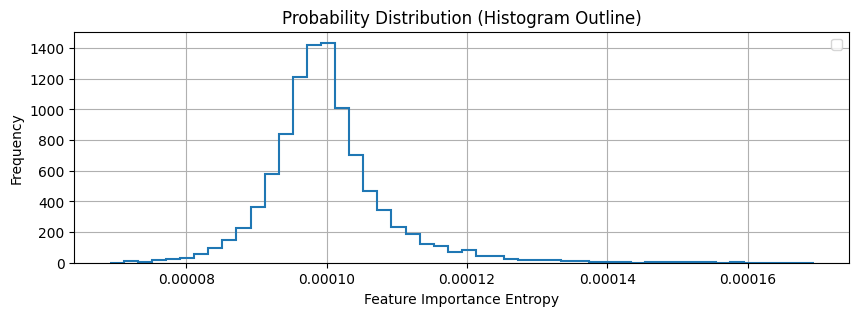

In [14]:
from holisticai.explainability.plots import plot_feature_importance
from holisticai.explainability.plots import plot_partial_dependence
from holisticai.explainability.plots import plot_local_importance_distribution
from holisticai.explainability.plots import plot_predictions_vs_interpretability

plot_local_importance_distribution(local_importances)
plt.show()

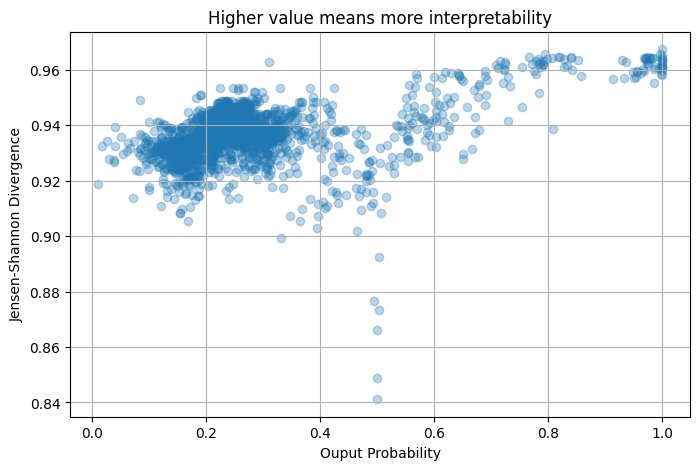

In [20]:
plot_predictions_vs_interpretability(local_importances.data['Metadata']['y_proba'], local_importances)
plt.show()

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

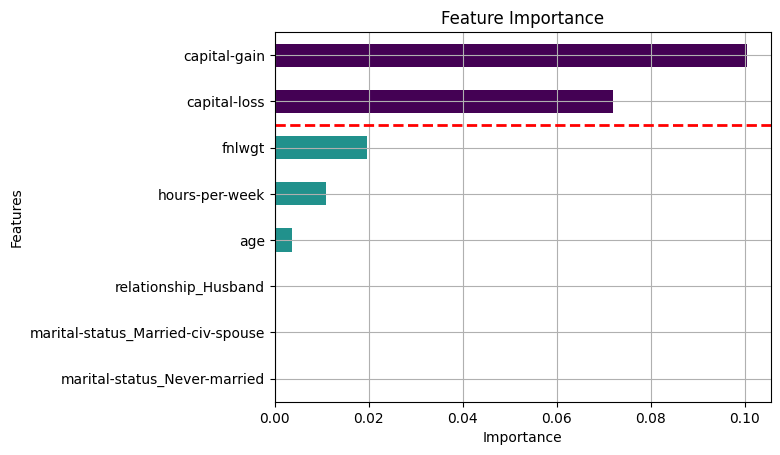

In [12]:
from holisticai.explainability.plots import plot_feature_importance

plot_feature_importance(importances, top_n=8)

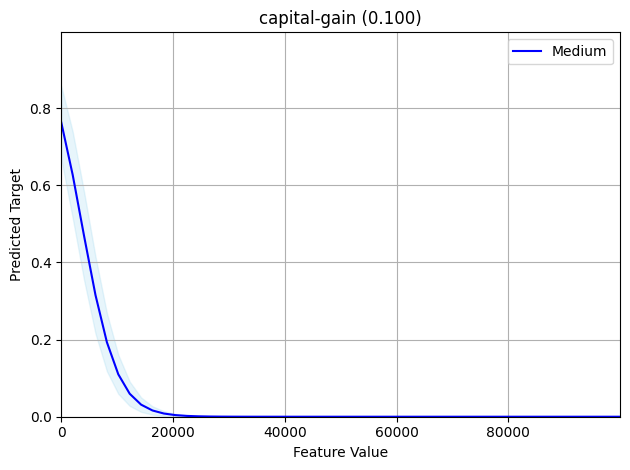

In [13]:
from holisticai.explainability.plots import plot_partial_dependence

class_index = 0
plot_partial_dependence(partial_dependencies, ranked_importances, class_idx=class_index)

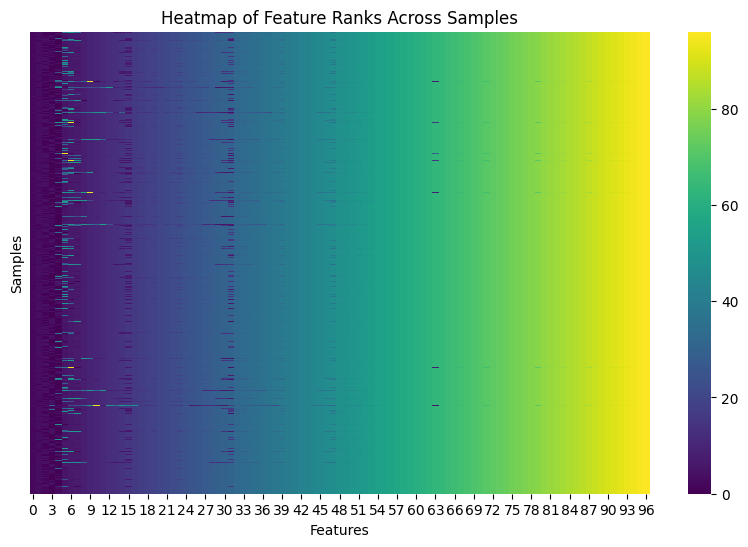

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming ranked_features has the ranks (M samples x d features)
ranked_features = np.argsort(-local_importances.values, axis=1)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ranked_features, cmap='viridis', cbar=True, yticklabels=False)
plt.title("Heatmap of Feature Ranks Across Samples")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()


# Multi Classification

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

from holisticai.datasets import load_dataset
from sklearn.metrics import accuracy_score

dataset = load_dataset(dataset_name="student_multiclass")
dataset = dataset.train_test_split(test_size=200, random_state=42, stratify=dataset['y'])   
train = dataset['train']
test = dataset['test']

model = GradientBoostingClassifier()
model.fit(train['X'], train['y'])

accuracy_score(test['y'], model.predict(test['X']))

In [ ]:
from holisticai.utils import MultiClassificationProxy
from holisticai.utils.feature_importances import compute_shap_feature_importance
from holisticai.utils.inspection import compute_partial_dependence

proxy = MultiClassificationProxy(predict=model.predict, predict_proba=model.predict_proba, classes=model.classes_)

local_importances = compute_shap_feature_importance(X=train['X'], proxy=proxy, max_samples=200)
local_conditional_importances = local_importances.conditional()

importances = local_importances.to_global()
conditional_importances = local_conditional_importances.to_global()

ranked_importances = importances.top_alpha(0.8)

partial_dependencies = compute_partial_dependence(test['X'], features=ranked_importances.feature_names, proxy=proxy)

y_pred = proxy.predict(test['X'])

In [ ]:
from holisticai.explainability.metrics import multiclass_explainability_metrics

multiclass_explainability_metrics(importances, partial_dependencies, conditional_importances, test['X'], y_pred, local_importances)

In [ ]:
from holisticai.explainability.plots import plot_feature_importance

plot_feature_importance(importances, top_n=30)

In [ ]:
from holisticai.explainability.plots import plot_partial_dependence

class_idx = 0 #1
plot_partial_dependence(partial_dependencies, ranked_importances, subplots=(3,4), figsize=(10,8), class_idx=class_idx)